## Spatial regression analysis for testing associations between gene expression and mechanical properties

- Use gSEM model to look for associations between gene expression and cellular mechanics while taking spatial confounding into account
- Do further analysis of genes identified as statistically significant
- Compare spatial regression to simple linear regression models

In [1]:
dataset <- 'embryo2_fmh'

### Preprocessing

#### Library imports

In [2]:
library(sp)
library(mgcv)
library(dplyr)
library(progress)
library(parallel)
library(ggplot2)
library(ggpubr)
library(doParallel)
library(EnhancedVolcano)
library(clusterProfiler)
library(org.Mm.eg.db)
library(stringr)
library(BuenColors)
library(grid)

Loading required package: nlme

This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.


Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: foreach

Loading required package: iterators

Loading required package: ggrepel

Warning message:
“package ‘clusterProfiler’ was built under R version 4.2.2”


clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘pack

#### Define functions for gSEM regression

In [3]:
# Do regression for one gene
do_gsem_regression <- function(gene, force_metric, tensionmap_res, gex_res, k_sp=300, model_fx=T, method='REML'){
  data_df <- tensionmap_res[,c('centroid_x', 'centroid_y', force_metric)]
  data_df[['force_metric']] <- log(data_df[[force_metric]])
  data_df[['gene']] <- t(gex_res[gene, rownames(data_df)])
  # Define variables for regression
  X <- data_df[['force_metric']]
  Y <- data_df[['gene']]
  
  #gSEM
  #Identify spatial patterns
  f_X_hat<-gam(force_metric~s(centroid_x,centroid_y,k=k_sp,fx=model_fx),data=data_df,method=method)$fitted.values
  r_X<-X-f_X_hat
  f_Y_hat<-gam(gene~s(centroid_x,centroid_y,k=k_sp,fx=model_fx),data=data_df,method=method)$fitted.values
  r_Y<-Y-f_Y_hat
  #Fit linear model to residuals
  mod<-lm(r_Y~r_X)
  
  return(list(mod, as.numeric(r_X), as.numeric(r_Y)))
}

# Parallelised regression for multiple genes
parallel_gsem_regression <- function(genes, tensionmap_res, gex_res, k_sp=300, model_fx=F, method='REML', ncores=6){
  registerDoParallel(ncores)
    
  reg_res <- foreach(i=icount(length(genes)), .combine=rbind) %dopar% {
    gene <- genes[i]
    
    res <- data.frame(gene=character(0), metric=character(0), beta=numeric(0), pval=numeric(0), stat=numeric(0))
    for (force_metric in c('pressure', 'stresstensor_magnitude')){
      reg_res <- do_gsem_regression(gene, force_metric, tensionmap_res, gex_res, k_sp, model_fx, method)
    
      mod <- reg_res[[1]]
      res <- rbind(res, data.frame(gene=gene, metric=force_metric, beta=mod$coefficients[2], pval=summary(mod)$coefficients[2,4], stat=summary(mod)$coefficients[2,3]))
    }
    res
  }
  
  return(reg_res)
}


In [4]:
tensionmap_res <- read.table(paste0('../reproduce_data/', dataset, '/tensionmap_res.csv', collapse=''), sep=',', header = T, row.names = 1)
gex_res <- read.table(paste0('../reproduce_data/', dataset, '/gex_res.csv', collapse=''), sep=',', header = T, row.names = 1)

In [5]:
tensionmap_res[['stresstensor_magnitude']] <- tensionmap_res[['stresstensor_eigval1']] + tensionmap_res[['stresstensor_eigval2']]

### Do spatial regression

Note: this step is computationally intensive as it takes ~10s to construct a model for each gene (tested on M1 Macbook Pro). For demonstration purposes we only do regression on a random subset of 100 genes.

In [6]:
# Find genes expressed in >50% of cells
expressed_genes <- rownames(gex_res)[apply(gex_res, 1, function(x){return(sum(x>0)/length(x))}) > 0.5]

In [7]:
# Randomly sample from expressed genes
set.seed(11235)

expressed_genes_subset <- sample(expressed_genes, 100, replace=F)

In [8]:
gsem_reg_res_smooth <- parallel_gsem_regression(expressed_genes_subset, tensionmap_res, gex_res, model_fx = T, ncores = 8)

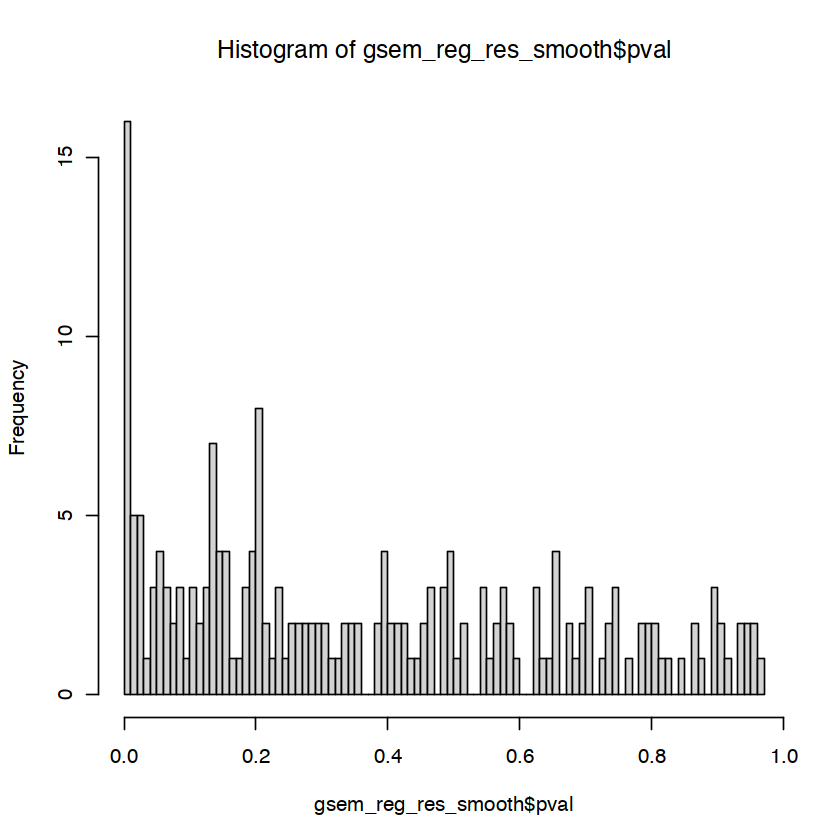

In [9]:
# Check distribution of p-values
hist(gsem_reg_res_smooth$pval, breaks=100)

In [10]:
gsem_reg_res_smooth$padj <- p.adjust(gsem_reg_res_smooth$pval, method = 'BH')

### Further analysis of results

#### Generate volcano plots
Note: for this analysis the adjusted p-value threshold has been set to 0.1 for illustrative purposes. The threshold value used for the full analysis is 0.05.

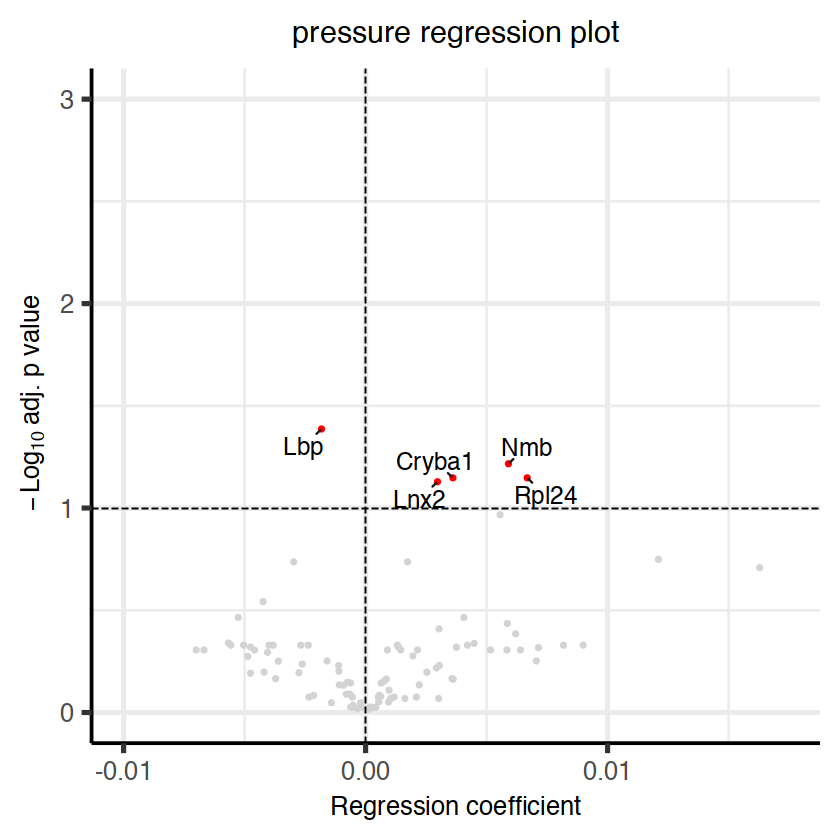

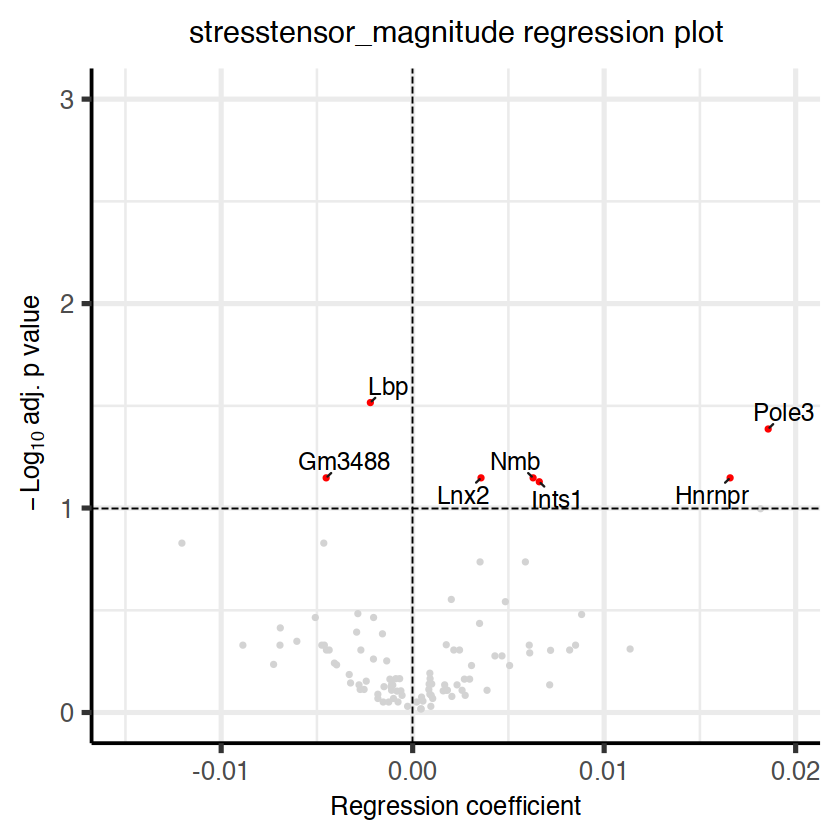

In [11]:
for (curr_metric in c('pressure', 'stresstensor_magnitude')) {
  metric_reg_res <- dplyr::filter(gsem_reg_res_smooth, metric==curr_metric)
  metric_reg_res <- dplyr::mutate(metric_reg_res, log_padj=-log10(padj))
  
  points_cols <- ifelse(metric_reg_res$padj < 0.1, 'red','lightgrey')
  names(points_cols) <- metric_reg_res$gene
  
  volcano_plot <- EnhancedVolcano(metric_reg_res,
                                  lab = metric_reg_res$gene,
#                                  selectLab = common_genes_selected[common_genes_selected %in% metric_reg_res$gene],
                                  drawConnectors = TRUE,
                                  x = 'beta',
                                  y = 'padj',
                                  pointSize = 1,
                                  subtitle = NULL,
                                  FCcutoff = 0,
                                  xlim = quantile(metric_reg_res$beta, c(0.001, 0.999)),
                                  ylim = c(0, 3),
                                  pCutoff = 0.1,
                                  caption = NULL,
                                  xlab = c('Regression coefficient'),
                                  ylab =  bquote(~-Log[10] ~ 'adj. p value'),
                                  axisLabSize = 15,
                                  colCustom = points_cols,
                                  arrowheads = FALSE,
                                  colAlpha = 1,
                                  legendPosition = 'none',
                                  title = paste(curr_metric,'regression plot',sep=' ')) +
    theme(plot.title = element_text(hjust = 0.5))
  print(volcano_plot)
}


#### Plot spatially regressed residuals for a single gene and mechanical property

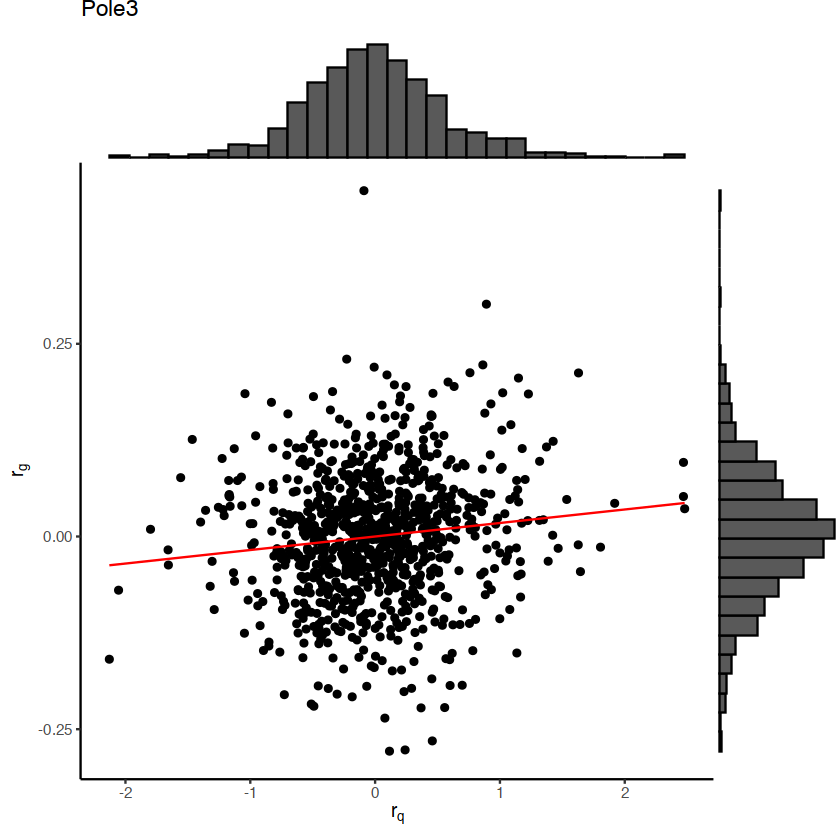

In [12]:
metric_use <- 'pressure'
gene <- dplyr::arrange(gsem_reg_res_smooth[gsem_reg_res_smooth$metric == metric_use, ], padj)[1,'gene']

gsem_reg_res_singlegene <- do_gsem_regression(gene, metric_use, tensionmap_res, gex_res)
plot_df <- data.frame(r_X = gsem_reg_res_singlegene[[2]], r_Y = gsem_reg_res_singlegene[[3]], fitted = gsem_reg_res_singlegene[[1]]$fitted.values)
p <- ggplot(plot_df) +
  geom_point(aes(x=r_X, y=r_Y)) +
  geom_line(aes(x=r_X, y=fitted), color='red') +
  ggtitle(gene) +
  theme_classic() +
  xlab(bquote(r[q])) +
  ylab(bquote(r[g]))
p <- ggExtra::ggMarginal(p, type = "histogram")
p

#### Do GO overrepresentation analysis
Note: code used here is the same as for the full analysis but results will differ as we only do regression for a subset of genes

In [13]:
# GO analysis
p_go_res <- enrichGO(gene      = gsem_reg_res_smooth[(gsem_reg_res_smooth$padj < 0.1) & (gsem_reg_res_smooth$metric == 'pressure'), 'gene'],
                     universe     = expressed_genes_subset,
                     OrgDb        = org.Mm.eg.db,
                     ont          = "BP",
                     keyType      = "SYMBOL", 
                     minGSSize    = 10,
                     maxGSSize    = 500,
                     pvalueCutoff = 1)

sm_go_res <- enrichGO(gene      = gsem_reg_res_smooth[(gsem_reg_res_smooth$padj < 0.1) & (gsem_reg_res_smooth$metric == 'stresstensor_magnitude'), 'gene'],
                      universe     = expressed_genes_subset,
                      OrgDb        = org.Mm.eg.db,
                      ont          = "BP",
                      keyType      = "SYMBOL", 
                      minGSSize    = 10,
                      maxGSSize    = 500,
                      pvalueCutoff = 1)


In [14]:
# Define function for pretty bar plots

makebarplot <- function(data, title, numpoints){
  data[['log10_pvalue']] <- -log10(data$pvalue)
  data_plot_df <- dplyr::arrange(data, desc(log10_pvalue))[1:numpoints,]
  data_plot_df$Description <- apply(str_split_fixed(data_plot_df$Description, '_', Inf), 1, paste, collapse=' ') %>% tolower()
  data_plot_df$Description <- str_wrap(data_plot_df$Description, width = 30)
  data_plot_df$Description <- factor(data_plot_df$Description, levels = rev(data_plot_df$Description))
  
  plot <- ggplot(data_plot_df, aes(x=log10_pvalue, y=Description, fill=Count)) +
    geom_bar(stat='identity') +
    xlab(bquote(~-Log[10] ~ 'p value')) +
    ylab(NULL) +
    ggtitle(title) +
    theme_bw() +
    scale_fill_gradientn(colours = jdb_palette('solar_rojos')[4:length(jdb_palette('solar_rojos'))]) + 
    theme(plot.title = element_text(hjust = 0.5, size=17, face="bold"), axis.text.y = element_text(size=14),
          panel.border = element_blank(), panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))
  return(plot)
}

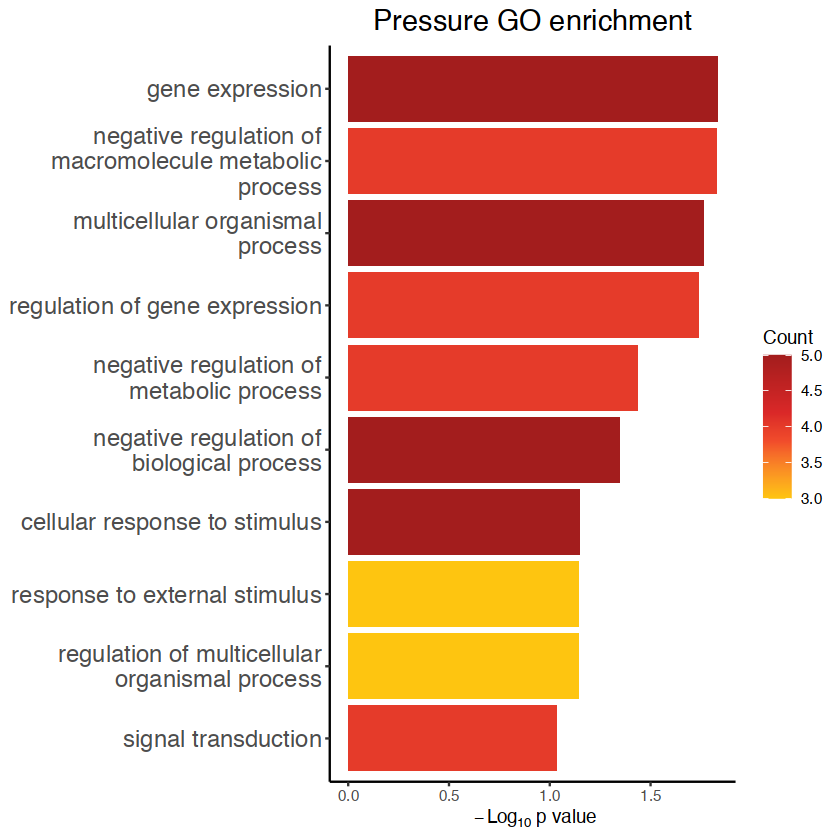

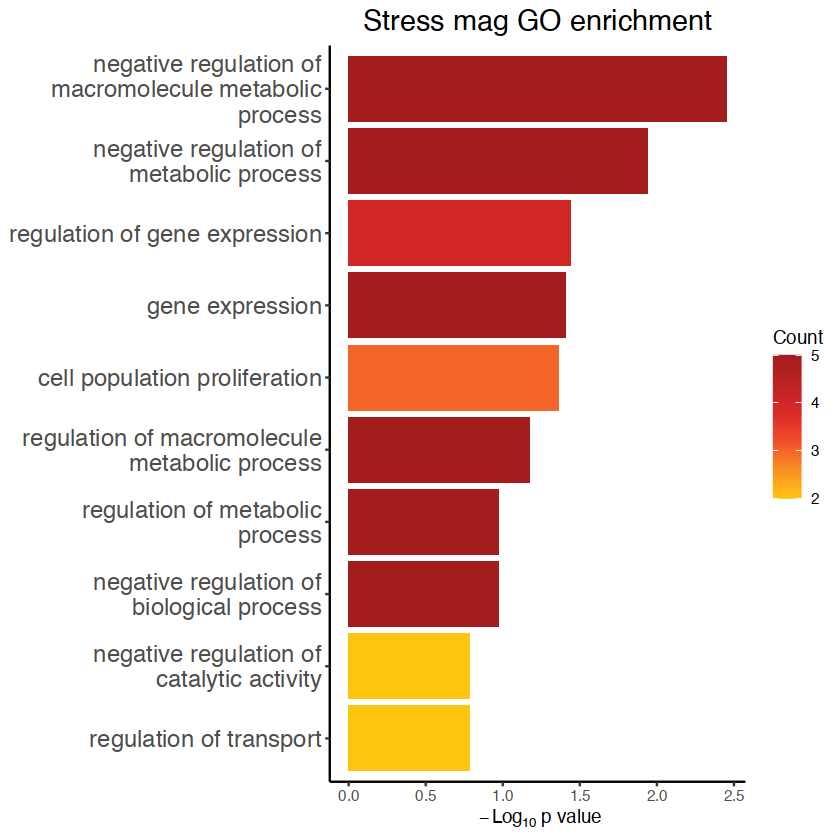

In [15]:
makebarplot(p_go_res@result, title = 'Pressure GO enrichment', 10)
makebarplot(sm_go_res@result, title = 'Stress mag GO enrichment', 10)

### Compare spatial regression to linear regression model

#### Define functions for parallel linear regression

In [16]:
do_linear_regresssion <- function(gene, force_metric, tensionmap_res, gex_res){
  data_df <- tensionmap_res[c('centroid_x', 'centroid_y', force_metric)]
  data_df[['force_metric']] <- log(data_df[[force_metric]])
  
  data_df[['gene']] <- t(gex_res[gene, rownames(data_df)])
  # Define variables for regression
  X <- data_df[['force_metric']]
  Y <- data_df[['gene']]
  
  mod<-lm(Y~X)
  return(list(mod, as.numeric(X), as.numeric(Y)))
}

# Parallelised regression for multiple genes
parallel_linear_regression <- function(genes, tensionmap_res, gex_res, ncores=6){
  registerDoParallel(ncores)
    
  reg_res <- foreach(i=icount(length(genes)), .combine=rbind) %dopar% {
    gene <- genes[i]
    
    res <- data.frame(gene=character(0), metric=character(0), beta=numeric(0), pval=numeric(0), stat=numeric(0))
    for (force_metric in c('pressure', 'stresstensor_magnitude')){
      reg_res <- do_linear_regresssion(gene, force_metric, tensionmap_res, gex_res)
    
      mod <- reg_res[[1]]
      res <- rbind(res, data.frame(gene=gene, metric=force_metric, beta=mod$coefficients[2], pval=summary(mod)$coefficients[2,4], stat=summary(mod)$coefficients[2,3]))
    }
    res
  }
  
  return(reg_res)
}

In [17]:
lin_reg_res <- parallel_linear_regression(expressed_genes_subset, tensionmap_res, gex_res, ncores = 8)

In [18]:
lin_reg_res %>% head()

,gene,metric,beta,pval,stat
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
X,Aurkb,pressure,-2.113004e-02,0.0013557968,-3.21378863
X1,Aurkb,stresstensor_magnitude,-2.075903e-02,0.0004900653,-3.49869757
X2,Fbxo46,pressure,9.269989e-05,0.9527430921,0.05927867
X11,Fbxo46,stresstensor_magnitude,7.566780e-05,0.9572950944,0.05356292
X3,Rhbdd3,pressure,-6.410536e-03,0.0126846074,-2.49742454
X12,Rhbdd3,stresstensor_magnitude,-2.925575e-03,0.2085420105,-1.25847230


#### Compare coefficients for spatial vs linear regression

In [19]:
comp_df <- merge(gsem_reg_res_smooth, lin_reg_res, by.x=c('gene','metric'), by.y=c('gene','metric'), suffixes=c('_gsem','_linreg'))

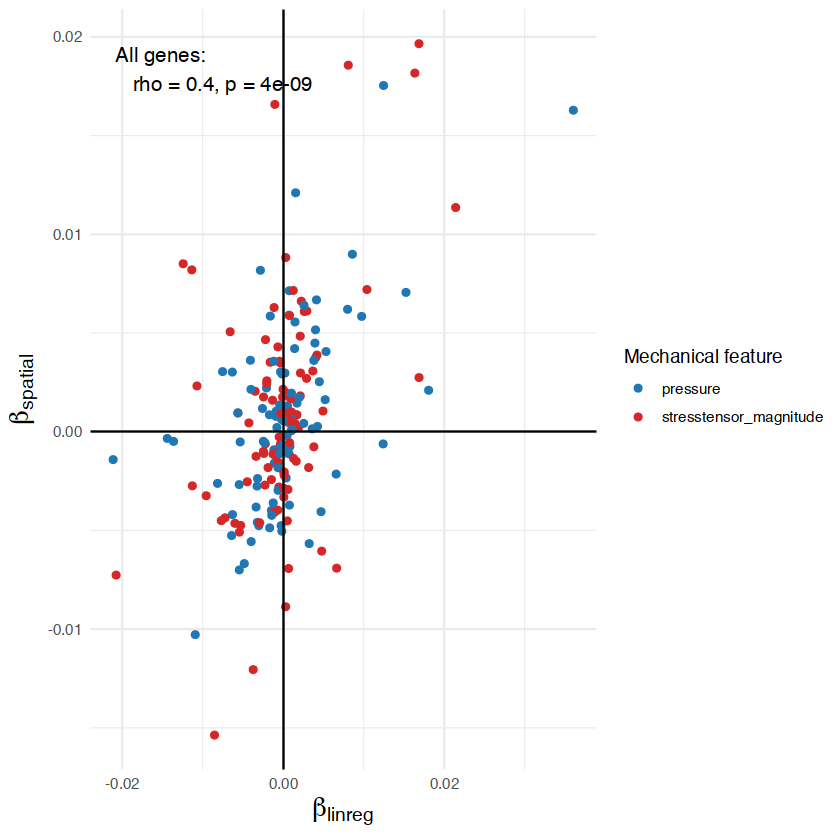

In [20]:
all_cor <- cor.test(comp_df$beta_gsem, comp_df$beta_linreg, method = 'spearman')
grob <- grobTree(textGrob(paste0("All genes:\n   rho = ",signif(all_cor$estimate,2),", p = ",signif(all_cor$p.value,2)), 
                            hjust=0, vjust=1, x=0.05,  y=0.95,
                            gp=gpar(col="black", fontface="italic", fontsize=12)))

ggplot() +
    geom_point(data=comp_df, aes(x=beta_linreg, y=beta_gsem, color=metric)) +
    geom_vline(xintercept = 0) +
    geom_hline(yintercept = 0) + 
    theme_minimal() +
    annotation_custom(grob) +
    ylab(bquote(beta[spatial])) +
    xlab(bquote(beta[linreg])) +
    scale_color_manual(values=jdb_palette('corona'),name = "Mechanical feature") +
    scale_alpha_continuous(name = bquote(~-Log[10] ~ 'p-value')) +
    theme(axis.title=element_text(size=16))